In [63]:
import sys
sys.path.append("/Users/david/Documents/mastersCode/ubm")
print(sys.path)

['/Applications/PyCharm.app/Contents/plugins/python/helpers-pro/jupyter_debug', '/Applications/PyCharm.app/Contents/plugins/python/helpers/pydev', '/Users/david/Documents/mastersCode/ubm/final/tests/selecting_amount_of_states_hmm', '/Users/david/.conda/envs/ubm/lib/python310.zip', '/Users/david/.conda/envs/ubm/lib/python3.10', '/Users/david/.conda/envs/ubm/lib/python3.10/lib-dynload', '', '/Users/david/.conda/envs/ubm/lib/python3.10/site-packages', '/Users/david/Documents/mastersCode/ubm', '/Users/david/Documents/mastersCode/ubm']


In [67]:
import pickle
from importlib import reload
import numpy as np
from hmmlearn.hmm import GaussianHMM

In [68]:
hmm_data = pickle.load(open(r'/Users/david/Documents/mastersCode/ubm/final/tests/get_features/humpback_cv_output_mfcc_normalised.pkl', 'rb'))

In [318]:
# define things for later

curr_train = hmm_data['train_data'][0]

curr_test = hmm_data['test_data']
curr_test_concat = np.concatenate(hmm_data['test_data'])
data_temp = hmm_data['train_data'][0][0]

ns = np.arange(2,21,1)
n_inits = np.arange(0,1,1)

In [245]:
import final.models.hdphmm.bhmm.bhmm as bhmm
import warnings
import final.models.hdphmm.helpers.plot_hmm as plot_hmm
import time
reload(plot_hmm)
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
reload(bhmm)
train = curr_train
import final.cross_validation as cv

def combine_into_new_training(combine_amt, train_list):
    len_training_data = len(train_list)
    amount_of_splits = int(len_training_data / combine_amt)
    split_training = cv.split_data_for_cross_validation(train_list, np.zeros(len(train_list)), amount_of_splits, 0.01)
    new_train_list = [np.concatenate(vals) for vals in split_training['val_data']]
    new_train_list[-1] = np.concatenate((new_train_list[-1], split_training['test_data'][0]), axis=0)
    return new_train_list
new_training = combine_into_new_training(4, hmm_data['train_data'][0])

In [250]:
my_bhmm = bhmm.BayesianHMM(X=new_training, K=20, iterations=50, alpha0=0.1, kappa0=10,
                           outer_its=10, verbose=True, convergence_check=100)
# plot_hmm.plot_hmm_data(new_training[0], my_bhmm.Z, my_bhmm.K, my_bhmm.mu, my_bhmm.sigma, feature_a=5, feature_b=6)

multiple sequences given


In [251]:
hmm_from_trace = my_bhmm.fit()

starting gibbs sampling
outer it:  0
it:  10 score:  -6757.214460181642 n-components:  20


[32 53 42 54 47 53 24 59 28 66 11 41 38 15 35 24 47 37 45 44]
it:  20 score:  -6615.5556246586575 n-components:  20


[33 53 46 54 50 54 20 59 26 66 12 37 34 14 32 27 47 37 51 43]
it:  30 score:  -6543.539137066268 n-components:  20


[33 53 44 56 47 53 15 62 28 64 12 37 35 17 32 24 47 38 56 42]
it:  40 score:  -6515.238539987295 n-components:  20


[32 53 45 55 48 52 14 63 29 62 13 37 34 20 28 27 45 38 55 45]
it:  50 score:  -6511.486663707765 n-components:  20


[32 52 46 56 47 54 14 62 28 62 13 38 35 20 30 24 46 37 55 44]
removing empty component(s)
it:  60 score:  0 n-components:  18


[83 30  2 76 55 81 45 15  7 46 27 37 16 20 29 33 41 31]
it:  70 score:  0 n-components:  18


[86 30  2 76 43 90 44 16  7 45 27 39 16 20 28 29 41 35]
it:  80 score:  -6013.046228777535 n-components:  18


[90 29  2 77 41 88 45 16  7 48 27 37 17 19 29 26 41 35]
it:  90 score:  -5999.503451130542 n-components:  

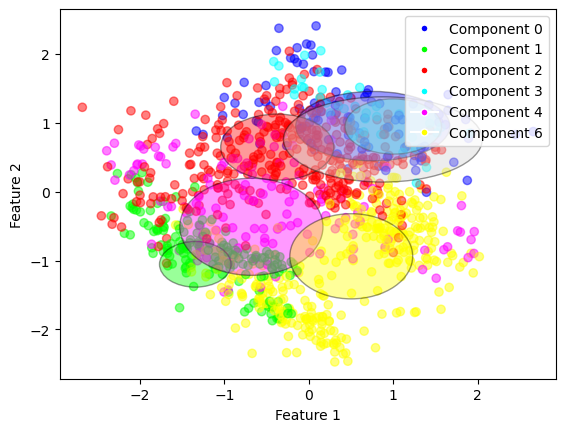

In [252]:
plot_hmm.plot_hmm_data(curr_test_concat, hmm_from_trace.predict(curr_test_concat), hmm_from_trace.n_components, hmm_from_trace.means_, hmm_from_trace.covars_, feature_a=8, feature_b=9)

In [253]:
hmm_from_trace.score(curr_test_concat)

-16291.12236142106

In [7]:
start_outer = time.time()
results_gibbs_finite = {}
results_per_component = {}
for n in ns:

    print('calculating for n: ', n)
    start_inner = time.time()
    total_inits = 0
    lls = []
    models = []
    models_gibbs = []
    final_components = []

    for cv_index in range(len(hmm_data['train_data'])):
        curr_train = hmm_data['train_data'][cv_index]
        curr_val = hmm_data['val_data'][cv_index]

        for i in n_inits:
            total_inits += 1

            my_bhmm = bhmm.BayesianHMM(X=curr_train, K=n, iterations=50, alpha0=0.5, kappa0=10, outer_its=1000, verbose=False, convergence_check=200)
            curr_hmm = my_bhmm.fit()
            ll = curr_hmm.score(np.concatenate(curr_val))

            # append
            lls.append(ll)
            models.append(curr_hmm)
            models_gibbs.append(my_bhmm)

            # final components from A matrix
            final_components.append(curr_hmm.n_components)

    best_model = np.argmax(lls)
    average_score = np.mean(lls)
    end_inner = time.time()
    results_per_component[n] = {
        'lls': lls,
        'models': models,
        'models_gibbs': models_gibbs,
        'time': (end_inner - start_inner),
        'test': models[best_model].score(np.concatenate(curr_test)),
        'avg_val': average_score,
        'final_components': final_components,
        'final_components_mean': np.mean(final_components)
    }
    print('n comps: ', np.mean(final_components), 'test_val: ', results_per_component[n]['test'])

end_outer = time.time()
results_gibbs_finite['total_time'] = end_outer - start_outer
results_gibbs_finite['components'] = results_per_component
results_gibbs_finite['total_its'] = len(hmm_data['train_data']) * len(n_inits)
results_gibbs_finite['component_list'] = ns


calculating for n:  1
multiple sequences given
starting gibbs sampling
convergence criteria met!
Completed gibbs sampling -- Convergence:  True  -- In:  1.1576812267303467
multiple sequences given
starting gibbs sampling
convergence criteria met!
Completed gibbs sampling -- Convergence:  True  -- In:  0.7686100006103516
multiple sequences given
starting gibbs sampling
convergence criteria met!
Completed gibbs sampling -- Convergence:  True  -- In:  0.7583491802215576
multiple sequences given
starting gibbs sampling
convergence criteria met!
Completed gibbs sampling -- Convergence:  True  -- In:  0.7597849369049072
multiple sequences given
starting gibbs sampling
convergence criteria met!
Completed gibbs sampling -- Convergence:  True  -- In:  0.74143385887146
multiple sequences given
starting gibbs sampling
convergence criteria met!
Completed gibbs sampling -- Convergence:  True  -- In:  0.7402470111846924
multiple sequences given
starting gibbs sampling
convergence criteria met!
Compl

In [8]:
output = open('results_gibbs_finite' + ".pkl", "wb")
pickle.dump(results_gibbs_finite, output)
output.close()

In [12]:
# results_gibbs_finite = pickle.load(open(r'/Users/david/Documents/mastersCode/ubm/final/models/hdphmm/bhmm/testing/results_gibbs_finite.pkl', 'rb'))

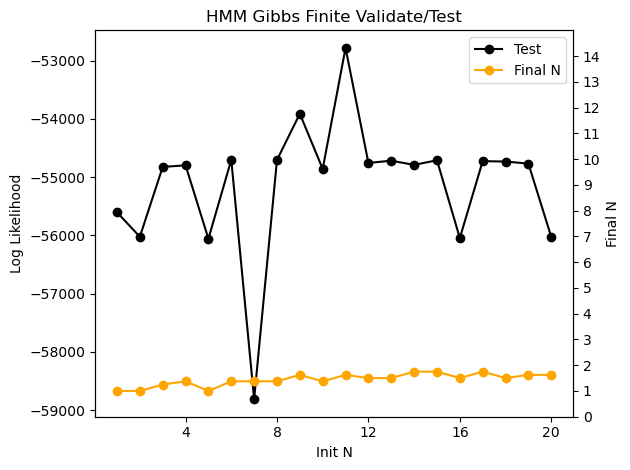

In [11]:
import matplotlib.pyplot as plt

components_results = results_gibbs_finite['components']
color1, color2, color3 = plt.cm.viridis([0, .5, .9])

avg_val_ll = [components_results[some_key]['avg_val'] for some_key in components_results]
test_ll = [components_results[some_key]['test'] for some_key in components_results]
final_components = [components_results[some_key]['final_components_mean'] for some_key in components_results]

fig, ax = plt.subplots()

# ax.plot(ns, avg_val_ll, color='blue', label='Val', marker='o')
ax.plot(ns, test_ll, color='black', label='Test', marker='o')

ax2 = ax.twinx()
ax2.plot(ns, final_components, color='orange', label='Final N', marker='o')
ax2.set_ylim(0,15)
ax2.set_yticks(np.arange(0,15,1))

ax.set_xticks(np.arange(4,21,4))

# ax3 = ax.twinx()
# ax3.plot(ns, elbo, label='Elbo', marker='o', color='green')
# ax3.set_ylabel("Elbo")
# ax3.spines['right'].set_position(('outward', 60))
# ax3.set_ylim(-0.1,0.15)

ax.legend(handles=ax.lines + ax2.lines) # + ax3.lines)
ax.set_title("HMM Gibbs Finite Validate/Test")
ax.set_ylabel("Log Likelihood")
ax2.set_ylabel("Final N")
ax.set_xlabel("Init N")
all_axes = fig.get_axes()
for axis in all_axes:
    legend = axis.get_legend()
    if legend is not None:
        legend.remove()
        all_axes[-1].add_artist(legend)
fig.tight_layout()
plt.show()


In [17]:
print('max finite gibbs test value: ', np.max([results_gibbs_finite['components'][some_key]['test'] for some_key in results_gibbs_finite['components']]), (np.argmax([results_gibbs_finite['components'][some_key]['test'] for some_key in results_gibbs_finite['components']])), results_gibbs_finite['total_time'])

max finite gibbs test value:  635.35327729011 10 439.10465002059937


In [5]:
import final.models.hdphmm.helpers.plot_hmm as plot_hmm
reload(plot_hmm)

temp = np.argmax([results_gibbs_finite['components'][some_key]['test'] for some_key in results_gibbs_finite['components']])
hmm_temp = results_gibbs_finite['components'][10 + 1]['models'][0]
plot_hmm.plot_hmm_data(data_temp, hmm_temp.predict(data_temp), hmm_temp.n_components, hmm_temp.means_, hmm_temp.covars_, feature_a=0, feature_b=1, legend=False, title='Finite Gibbs Components')

NameError: name 'results_gibbs_finite' is not defined

# [2] Direct Assignment Infinite HMM

In [124]:
import final.models.hdphmm.hdphmmda.hdp_hmm_da as hdp_hmm_da
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
reload(hdp_hmm_da)

my_hdphmm_da = hdp_hmm_da.InfiniteDirectSamplerHMM(new_training, K=20, outer_its=10, iterations=20, convergence_check=300, verbose=True, max_its=1000)

multiple sequences given


In [125]:
fitted_hmm = my_hdphmm_da.fit()

outer it:  0
warning self.nk == nk) != True:
ll:   -5670.570404435789
it:  10  --  2.400024175643921 nk:  20


KeyboardInterrupt: 

In [104]:
fitted_hmm = my_hdphmm_da.hmm_from_trace(11, 30)

score:  -56762.75965778717 Components:  11


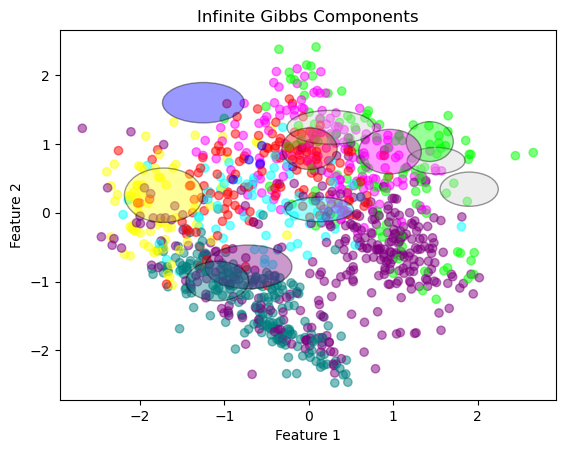

In [105]:
print('score: ', fitted_hmm.score(curr_test_concat), 'Components: ',fitted_hmm.n_components)
plot_hmm.plot_hmm_data(curr_test_concat, fitted_hmm.predict(curr_test_concat), fitted_hmm.n_components, fitted_hmm.means_, fitted_hmm.covars_, feature_a=8, feature_b=9, legend=False, title='Infinite Gibbs Components')

In [356]:
import final.models.hdphmm.hdphmmwl.hdphmmwl as hdphmmwl
reload(hdphmmwl)
# sbp = {
#     'gamma0': 2,
#     'alpha0': 0.5,
#     'kappa0': 10
# }

sbp = {
    'gamma0': 2,
    'alpha0': 0.5,
    'kappa0': 10
}

new_training_v2 = combine_into_new_training(2, curr_train)

my_hdphmm_wl = hdphmmwl.HDPHMMWL(np.concatenate(curr_train), K=30, outer_its=100, iterations=10000, convergence_check=10000, max_it=10000, sbp=sbp)

single sequence given
sbp given


In [357]:
curr_hmm = my_hdphmm_wl.fit_multiple(verbose=True)

starting gibbs sampling
it:  1  || Likelihood:  -1771.640246070362  || n_components:  17
it:  51  || Likelihood:  -1885.8489082057445  || n_components:  11
it:  101  || Likelihood:  -2021.4552066118786  || n_components:  10
it:  151  || Likelihood:  -2221.0324386559105  || n_components:  11
it:  201  || Likelihood:  -1599.266510466114  || n_components:  12
it:  251  || Likelihood:  -1918.1652606366258  || n_components:  16
it:  301  || Likelihood:  -2209.1709141297365  || n_components:  11
it:  351  || Likelihood:  -1803.7858561762978  || n_components:  11
it:  401  || Likelihood:  -2216.672870362764  || n_components:  9
it:  451  || Likelihood:  -2231.5448336811837  || n_components:  7
it:  501  || Likelihood:  -1759.9389025416688  || n_components:  12
it:  551  || Likelihood:  -1605.28570020632  || n_components:  11
it:  601  || Likelihood:  -1546.628144857957  || n_components:  8
it:  651  || Likelihood:  -2083.2010953287313  || n_components:  11
it:  701  || Likelihood:  -1969.4953

KeyboardInterrupt: 

In [358]:
np.round(np.mean(my_hdphmm_wl.trace['n_components'][-100:]))

11.0

-20717.928684202834 11


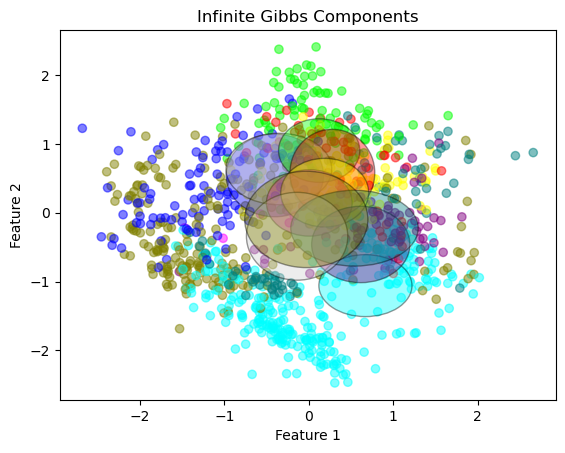

In [359]:
curr_hmm = my_hdphmm_wl.hmm_from_trace(11,100)
print(curr_hmm.score(np.concatenate(curr_test)), curr_hmm.n_components)
plot_hmm.plot_hmm_data(np.concatenate(curr_test), curr_hmm.predict(np.concatenate(curr_test)), curr_hmm.n_components, curr_hmm.means_, curr_hmm.covars_, feature_a=8, feature_b=9, legend=False, title='Infinite Gibbs Components')
# -17296.71479720391 10

In [55]:
import time

In [323]:

start_outer = time.time()
results_gibbs_infinite = {}
results_per_component = {}
for n in ns:
    print('------ || calculating for n: ', n, ' || ---------')
    start_inner = time.time()
    total_inits = 0
    lls = []
    models = []
    models_gibbs = []
    final_components = []

    for cv_index in range(len(hmm_data['train_data'])):
        curr_train = hmm_data['train_data'][cv_index]
        curr_val = hmm_data['val_data'][cv_index]

        for i in n_inits:
            total_inits += 1

            my_hdphmm_wl = hdphmmwl.HDPHMMWL(curr_train, K=n, outer_its=100, iterations=50, convergence_check=200, max_it=1000)
            curr_hmm = my_hdphmm_wl.fit_multiple(False)
            ll = curr_hmm.score(np.concatenate(curr_val))

            # append
            lls.append(ll)
            models.append(curr_hmm)
            models_gibbs.append(my_hdphmm_wl)

            # final components from A matrix
            final_components.append(curr_hmm.n_components)

    best_model = np.argmax(lls)
    average_score = np.mean(lls)
    end_inner = time.time()
    results_per_component[n] = {
        'lls': lls,
        'models': models,
        'models_gibbs': models_gibbs,
        'time': (end_inner - start_inner),
        'test': models[best_model].score(np.concatenate(curr_test)),
        'avg_val': average_score,
        'final_components': final_components,
        'final_components_mean': np.mean(final_components),
        'final_components_max': models[best_model].n_components
    }
    print('n comps: ', models[best_model].n_components, 'test_val: ', results_per_component[n]['test'])

end_outer = time.time()
results_gibbs_infinite['total_time'] = end_outer - start_outer
results_gibbs_infinite['components'] = results_per_component
results_gibbs_infinite['total_its'] = len(hmm_data['train_data']) * len(n_inits)
results_gibbs_infinite['component_list'] = ns


------ || calculating for n:  2  || ---------
multiple sequences given
starting gibbs sampling
convergence criteria met!
completed gibbs sampling in  3.5392720699310303
multiple sequences given
starting gibbs sampling
convergence criteria met!
completed gibbs sampling in  0.8612971305847168
n comps:  2 test_val:  -24947.474222678113
------ || calculating for n:  3  || ---------
multiple sequences given
starting gibbs sampling
convergence criteria met!
completed gibbs sampling in  3.224199056625366
multiple sequences given
starting gibbs sampling
convergence criteria met!
completed gibbs sampling in  1.8859100341796875
n comps:  2 test_val:  -24410.459174618845
------ || calculating for n:  4  || ---------
multiple sequences given
starting gibbs sampling
max it met!
completed gibbs sampling in  6.243525981903076
multiple sequences given
starting gibbs sampling
convergence criteria met!
completed gibbs sampling in  2.183988094329834
n comps:  3 test_val:  -18046.903535335925
------ || ca

In [73]:
output = open('results_gibbs_infinite' + ".pkl", "wb")
pickle.dump(results_gibbs_infinite, output)
output.close()

In [74]:
# results_gibbs_infinite = pickle.load(open(r'/Users/david/Documents/mastersCode/ubm/final/models/hdphmm/bhmm/testing/results_gibbs_infinite.pkl', 'rb'))

In [324]:
import matplotlib.pyplot as plt

components_results = results_gibbs_infinite['components']
color1, color2, color3 = plt.cm.viridis([0, .5, .9])

avg_val_ll = [components_results[some_key]['avg_val'] for some_key in components_results]
test_ll = [components_results[some_key]['test'] for some_key in components_results]
argmax =  np.array([np.argmax(components_results[some_key]['lls']) for some_key in components_results])
final_components = np.array([components_results[some_key]['final_components'] for some_key in components_results])
argmax_components = [final_components[i, argmax[i]] for i in range(len(argmax))]

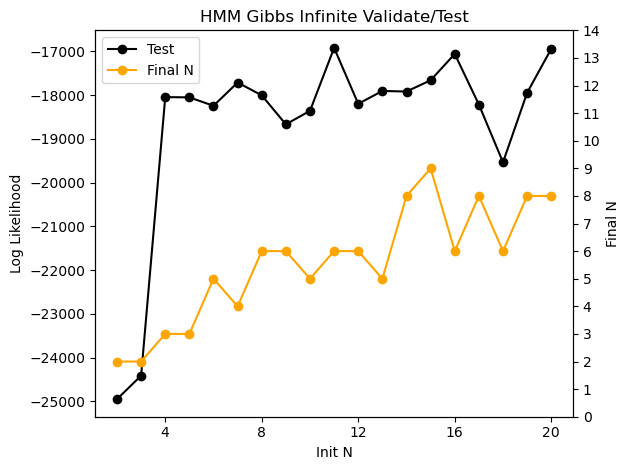

In [327]:
fig, ax = plt.subplots()

# ax.plot(ns, avg_val_ll, color='blue', label='Val', marker='o')
ax.plot(ns, test_ll, color='black', label='Test', marker='o')

ax2 = ax.twinx()
ax2.plot(ns, argmax_components, color='orange', label='Final N', marker='o')
# ax2.set_ylim(0,15)
ax2.set_yticks(np.arange(0,15,1))

ax.set_xticks(np.arange(4,21,4))

# ax3 = ax.twinx()
# ax3.plot(ns, elbo, label='Elbo', marker='o', color='green')
# ax3.set_ylabel("Elbo")
# ax3.spines['right'].set_position(('outward', 60))
# ax3.set_ylim(-0.1,0.15)

ax.legend(handles=ax.lines + ax2.lines) # + ax3.lines)
ax.set_title("HMM Gibbs Infinite Validate/Test")
ax.set_ylabel("Log Likelihood")
ax2.set_ylabel("Final N")
ax.set_xlabel("Init N")
all_axes = fig.get_axes()
for axis in all_axes:
    legend = axis.get_legend()
    if legend is not None:
        legend.remove()
        all_axes[-1].add_artist(legend)
fig.tight_layout()
plt.show()


In [328]:
print('max finite gibbs test value: ', np.max([results_gibbs_infinite['components'][some_key]['test'] for some_key in results_gibbs_infinite['components']]), (np.argmax([results_gibbs_infinite['components'][some_key]['test'] for some_key in results_gibbs_infinite['components']])), results_gibbs_infinite['total_time'])

max finite gibbs test value:  -16922.43732256029 9 343.83978271484375


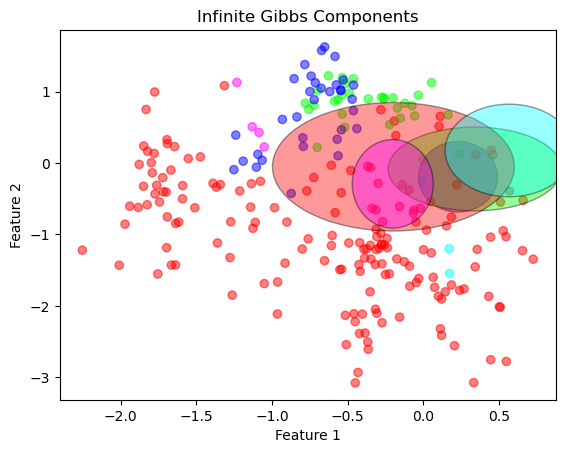

In [330]:
import final.models.hdphmm.helpers.plot_hmm as plot_hmm
reload(plot_hmm)

data_temp = hmm_data['train_data'][0][0]

temp = np.argmax([results_gibbs_infinite['components'][some_key]['test'] for some_key in results_gibbs_infinite['components']])
hmm_temp = results_gibbs_infinite['components'][9 + 2]['models'][0]
plot_hmm.plot_hmm_data(data_temp, hmm_temp.predict(data_temp), hmm_temp.n_components, hmm_temp.means_, hmm_temp.covars_, feature_a=0, feature_b=1, legend=False, title='Infinite Gibbs Components')